# Using SAS DLPy to Create a SAS Viya AutoEncoder Deep Learning Model

The following example demonstrates how to create a SAS Viya autoencoder deep learning model using the SAS DLPy API. The autoencoder model in this example is trained on images of dolphins, and the fidelity of the reconstructed image(s) is shown at the conclusion of the example.

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download the Input Image Data](#downloadData)   
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Connect to a SAS CAS Session](#SASCAS)
- [Load and Process the Input Images in SAS CAS](#loadInputs)
- [Use SAS DLPy to Define the Autoencoder Model Architecture and Compile the Model](#defineCompile)
- [Train the Compiled SAS Viya Autoencoder Model](#trainAutoencoder)
- [Use Trained SAS Viya Autoencoder Model to Score Image Data](#scoreData)
- [Use SAS Viya Autoencoder Model Output to Recreate Images](#recreateImages)
- [Display the Recreated Model Images](#displayResults)

<a id="ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system.


In [1]:
# This code defines variables that contain path specifications to  
# the input image files

# Server Autoencoder Image Root location (your path will be different)
server_autoencoder_image_root = r'/your/path/to/Autoencoder/Images' 


<a id="getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources that you will need and configure your local computing environment for this notebook example. Performing these tasks in advance means you can run the example without multiple stops to locate and download necessary resources. This approach enables you to focus on how to use SAS DLPy to complete the modeling task in this notebook.

<a id="downloadData"></a>

#### Download the Input Image Data

This notebook uses a subset of a small toy data set that contains dolphin and giraffe images. This example uses the dolphin images from the Giraffe_Dolphin toy data set. You can download the Dolphin subset of the example image data from the SAS DLPy repository on GitHub [here:](https://github.com/sassoftware/python-dlpy/tree/master/dlpy/tests/datasources/giraffe_dolphin_small/Dolphin)

Download the input Dolphin images to the server-side folder that you specified previously in the `server_autoencoder_image_root` variable.

When downloading the data to your server, the folder for the dolphin images in the example should be structured as follows:

* Dolphin
    * Dolphin image 1
    * Dolphin image 2
    * ...       

Now you can use the `server_autoencoder_image_root` variable to point to the location of the downloaded Dolphin input data images. 

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

After copying the input image data to your server, configure your client computing environment for the deep learning autoencoder model using Python and SAS DLPy. 

Import the various Python and SAS DLPy modules that this notebook uses. Begin by importing the SAS Scripting Wrapper for Analytic Transfer (SWAT). SWAT is the Python interface to SAS CAS. You can find more detailed information about starting a SAS CAS session with the SWAT package [here](https://sassoftware.github.io/python-swat/getting-started.html). 

Import the SAS DLPy modules and functions that are used to create the autoencoder model in this notebook. The DLPy `ImageTable` module makes it easier to load images from a folder into a SAS CAS table. The DLPy `model` module contains model parameters used to train and optimize the encoder / decoder model.


In [2]:
# Configure SAS CAS Computing Environment

# Import necessary module from SAS SWAT
from swat import CAS

# Import Python OS module for system interaction
import os

# Import SAS DLPy API
import dlpy

# Import SAS DLPy API modules
from dlpy.images import ImageTable
from dlpy.model import Optimizer, Model, DataSpec, AdamSolver, StepLR
from dlpy.layers import *
from dlpy.utils import display_segmentation_images


<a id="SASCAS"></a>

### Connect to a SAS CAS Session

SAS CAS is the distributed cloud computing environment for SAS Viya. SAS Viya models and the SAS DLPy API require a SAS CAS server session. Connect to SAS CAS by specifying your SAS CAS host name and a unique port ID. SAS example notebooks frequently use port 5570, but you can choose and assign your own PortID value. 

In [3]:
# Connect to your SAS CAS server
conn = CAS('your-server.unx.your-company.com', 5570)

# Load the SAS CAS image and deeplearn Action Sets
conn.loadactionset('image')
conn.loadactionset('deeplearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deeplearn'.


[actionset]

 'deeplearn'

+ Elapsed: 0.00357s, user: 0.000304s, sys: 0.00321s, mem: 0.221mb

<a id="loadInputs"></a>

### Load and Process the Input Images in SAS CAS

Use the imported SAS DLPy `ImageTable` class to populate a CAS table with images and image metadata from a folder. The `server_autoencoder_image_root` variable contains the server-side path to the image directory. This path <b>must</b> be accessible by the CAS server session.

The code below loads the dolphin images into a SAS CAS table and uniformly resizes the dolphin input images to 68 pixels by 68 pixels. 

In [4]:
# load_the Input Image Data of Dolphins 
# into SAS CAS and Resize the Images

# Set value of `image_dim` to 68 pixels
image_dim = 68

# Load the image data into SAS CAS as a table
image_data = ImageTable.load_files(conn=conn, 
                                   path=server_autoencoder_image_root, 
                                   casout=dict(name='data_input')
                                  )

# Use 'resize()' function to set all image
# dimensions to 68 pixels x 68 pixels
image_data = image_data.resize(width=image_dim, 
                               height=image_dim, 
                               inplace=False)

# Display Columns Infor for new CAS Table 'image_data'
image_data.columninfo()

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_filename_0,,1,varchar,17,17,,0,0
1,_label_,,2,varchar,0,1,,0,0
2,_image_,,3,varbinary(image),5577,5577,,0,0
3,_id_,,4,int64,8,12,,0,0


As a reality check, use the `show()` function to display random images from the SAS CAS table 'image_data'. You do this in order to verify correct images and image sizing in the new table:

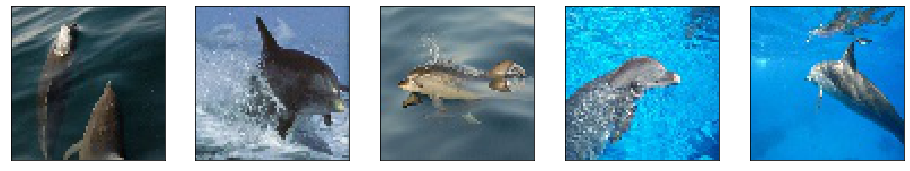

In [5]:
# Examine resized images
image_data.show()

<a id="defineCompile"></a>

### Use SAS DLPy to Define the Autoencoder Model Architecture and Compile the Model

The following code specifies the layer-by-layer architecture used in the new autoencoder model, and then compiles the deep learning autoencoder model. 

After the model is compiled, use the `summary` command to display a table showing the model's layer-by-layer architecture before training the model in the subsequent step. 


In [6]:
# If values for the width and height change, it is not ensured that 
# the outputs of the model keep the same dimension as the input

# Input Layer
data_input = Input(n_channels=3, 
                   width=image_dim, 
                   height=image_dim, 
                   name='Input', 
                   scale = 1.0 / 255
                  )
# 2D Convolution Layer 1
conv_1 = Conv2d(n_filters=16, 
                width=3, 
                height=3, 
                stride=1, 
                padding=1, 
                act='elu')(data_input)

# Pooling Layer 1
pool_1 = Pooling(width=2, 
                 height=2, 
                 stride=2, 
                 padding=0, 
                 pool='max')(conv_1)

# 2D Convolution Layer 2
conv_2 = Conv2d(n_filters=8, 
                width=3, 
                height=3, 
                stride=1, 
                padding=1, 
                act='elu')(pool_1)

# Pooling Layer 2
pool_2 = Pooling(width=2, 
                 height=2, 
                 stride=2, 
                 padding=0, 
                 pool='max')(conv_2)

# 2D Convolution Layer 3
conv_3 = Conv2d(n_filters=8, 
                width=3, 
                height=3, 
                stride=1, 
                padding=1, 
                act='elu')(pool_2)

# Encoder 
encoder = Pooling(width=2, 
                  height=2, 
                  stride=2, 
                  padding=1, 
                  pool='max', 
                  name='encoder')(conv_3)

# 2D Convolution Layer 4
conv_4 = Conv2d(n_filters=8, 
                width=3, 
                height=3, 
                stride=1, 
                padding=1, 
                act='elu')(encoder)

# Upsample 1
upsample_1 = Conv2DTranspose(8, 
                             3, 
                             padding=1, 
                             stride=2, 
                             act='relu')(conv_4)

# 2D Convolution Layer 5
conv_5 = Conv2d(n_filters=8, 
                width=3, 
                height=3, 
                stride=1, 
                padding=1, 
                act='elu')(upsample_1)

# Upsample 2
upsample_2 = Conv2DTranspose(8, 
                             4, 
                             padding=1, 
                             stride=2, 
                             act='relu')(conv_5)

# 2D Convolution Layer 6 
conv_6 = Conv2d(n_filters=16, 
                width=3, 
                height=3, 
                stride=1, 
                padding=1, 
                act='elu')(upsample_2)

# Upsample 3
upsample_3 = Conv2DTranspose(16, 
                             4, 
                             padding=1, 
                             stride=2, 
                             act='relu')(conv_6)

# Decoder 
decoder = Conv2d(n_filters=3, 
                 width=3, 
                 height=3, 
                 stride=1, 
                 padding=1, 
                 act='logistic', 
                 name='decoder')(upsample_3)

# Specify 'seg1' Segmentation Model
seg1 = Segmentation(name='Segmentation_1', 
                    target_scale = 1.0 / 255)(decoder)

# Load specified segmentation model architcture into SAS CAS
model = Model(conn, 
              inputs=data_input, 
              outputs=seg1, 
              model_table='auto_encoder'
             )

# Compile the model
model.compile()

# Now display a summary of the newly compiled model
model.summary

NOTE: Model compiled successfully.


,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input,input,,,None,"(68, 68, 3)","(0, 0)",0
1,1,Conv2d_1,convo,"(3, 3)","(1, 1)",Elu,"(68, 68, 16)","(432, 16)",1997568
2,2,Pooling_1,pool,"(2, 2)","(2, 2)",Max,"(34, 34, 16)","(0, 0)",0
3,3,Conv2d_2,convo,"(3, 3)","(1, 1)",Elu,"(34, 34, 8)","(1152, 8)",1331712
4,4,Pooling_2,pool,"(2, 2)","(2, 2)",Max,"(17, 17, 8)","(0, 0)",0
5,5,Conv2d_3,convo,"(3, 3)","(1, 1)",Elu,"(17, 17, 8)","(576, 8)",166464
6,6,encoder,pool,"(2, 2)","(2, 2)",Max,"(9, 9, 8)","(0, 0)",0
7,7,Conv2d_4,convo,"(3, 3)","(1, 1)",Elu,"(9, 9, 8)","(576, 8)",46656
8,8,Conv2DTranspose_1,transconvo,"(3, 3)","(2, 2)",Relu,"(17, 17, 8)","(576, 8)",166464
9,9,Conv2d_5,convo,"(3, 3)","(1, 1)",Elu,"(17, 17, 8)","(576, 8)",166464


<a id="trainAutoencoder"></a>

### Train the Compiled SAS Viya Autoencoder Model 

Now use the SAS DLPy `fit()` function and the ADAM solver to train the autoencoder model.

In [7]:
# Train the Autoencoder model

# Specify variable values for dataSpecs
data_specs = [DataSpec(type_='IMAGE', 
                       layer='Input', 
                       data=['_image_']
                      ),
              
              DataSpec(type_='IMAGE', 
                       layer='Segmentation_1', 
                       data_layer='Input')
             ]

# Specify ADAM solver parameter values 
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.005, 
                                        step_size=30, 
                                        gamma=0.95
                                       ),
                    
                    clip_grad_max = 100, 
                    clip_grad_min = -100
                   )

# Specify optimizer settings
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=10, 
                      log_level=2, 
                      max_epochs=100, 
                      reg_l2=0.0005, 
                      seed=13309
                     )

# Use DLPy 'fit()' to train the model
r = model.fit(data = image_data, 
              data_specs = data_specs, 
              optimizer = optimizer, 
              force_equal_padding = True, 
              n_threads=1
             )

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.
NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 10691.
NOTE:  The approximate memory cost is 45.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.03 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 10.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 10.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0         0.005           433.4     0.2066     0.42
NOTE:  1         0.005           355.3     0.1864     0.42
NOTE:  2         0.005           314.4     0.1709     0.46
NOTE:  3         0.005           309.1     0.1695   

<a id="scoreData"></a>

### Use Trained SAS Viya Autoencoder Model to Score Image Data

Now use the trained autoencoder model to regenerate the input images. 

In [8]:
# Model performs inference to score
model.score(image_data,
            model="AUTO_ENCODER",
            init_weights="AUTO_ENCODER_WEIGHTS",
            layers=['Segmentation_1'],
            layer_out='AutoEncoderOutput',
            layer_image_type='WIDE'
           )

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            49
 1  Number of Observations Used            49
 2          Mean Absolute Error      0.088293
 3                   Loss Error       101.456

[OutputCasTables]

             casLib               Name  Rows  Columns  \
 0  CASUSER(userid)  AutoEncoderOutput    49    13872   
 
                                             casTable  
 0  CASTable('AutoEncoderOutput', caslib='CASUSER(...  

+ Elapsed: 0.162s, user: 0.588s, sys: 0.283s, mem: 431mb

<a id="recreateImages"></a>
       
### Use SAS Viya Autoencoder Model Output to Recreate Images

The following code uses the `condenseimages()` function and the output of the autoencoder model (previous step) to re-create images from the vectorized output of the autoencoder and save them as `final_images`. The purpose of the following two steps is to enable the user to visualize the output results and validate the autoencoder model output:

In [9]:
# Re-create Images from the Output layer
conn.image.condenseimages(table='AutoEncoderOutput',
                          width=image_dim, 
                          height=image_dim,
                          casout=dict(name='final_images', 
                                      replace=True
                                     ),
                          groupedChannels=True,
                          numberofchannels=3,
                          depth='BIT32'
                         )

NOTE: 49 out of 49 images were processed successfully and saved to the Cloud Analytic Services table final_images.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(userid),final_images,,49,5,"CASTable('final_images', caslib='CASUSER(docai..."


The following code uses the `processimages()` function to rescale the model output to 8 bit format. This enables you to see the output from the autoencoder model in image format.

In [10]:
# Re-scale output images to 8-bit depth
conn.image.processimages(table='final_images',
                         imageFunctions=[dict(functionOptions=dict(functionType='RESCALE'
                                                                   ,alpha=255.0))],
                         casOut=dict(name='final_images_rescaled', 
                                     replace=True)
                        )

NOTE: Table FINAL_IMAGES contains decompressed images.
NOTE: 49 out of 49 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table final_images_rescaled.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(userid),final_images_rescaled,,49,5,"CASTable('final_images_rescaled', caslib='CASU..."


<a id="displayResults"> </a>

### Display the Recreated Model Images

Now you can use the SAS DLPy `display_segmentation_images()` function to show the decoded versions of encoded images created by the autoencoder model. The first row in the output display contains the original images. The second row in the output display contains the encoded image reconstructions from `final_images_rescaled`.

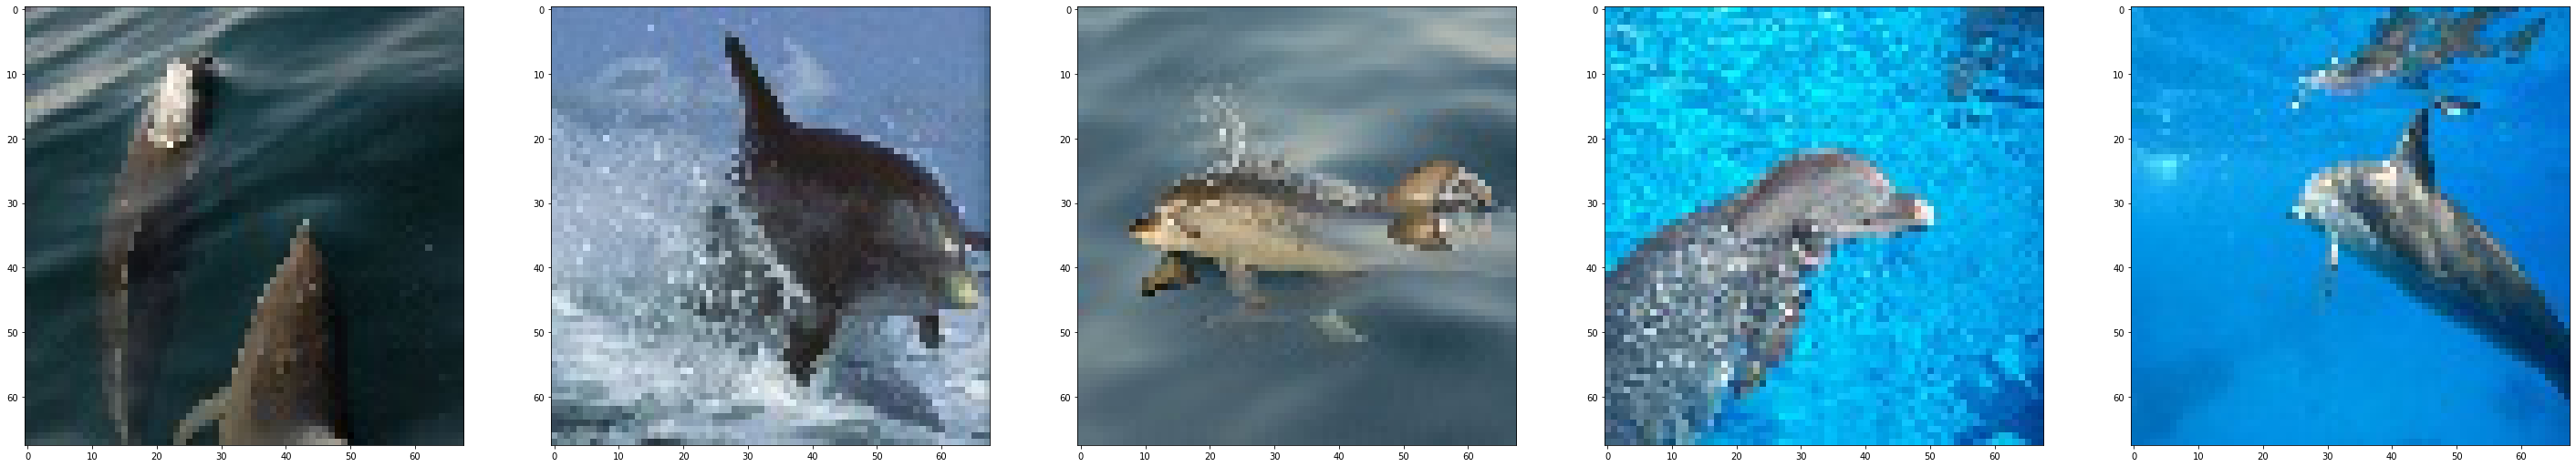

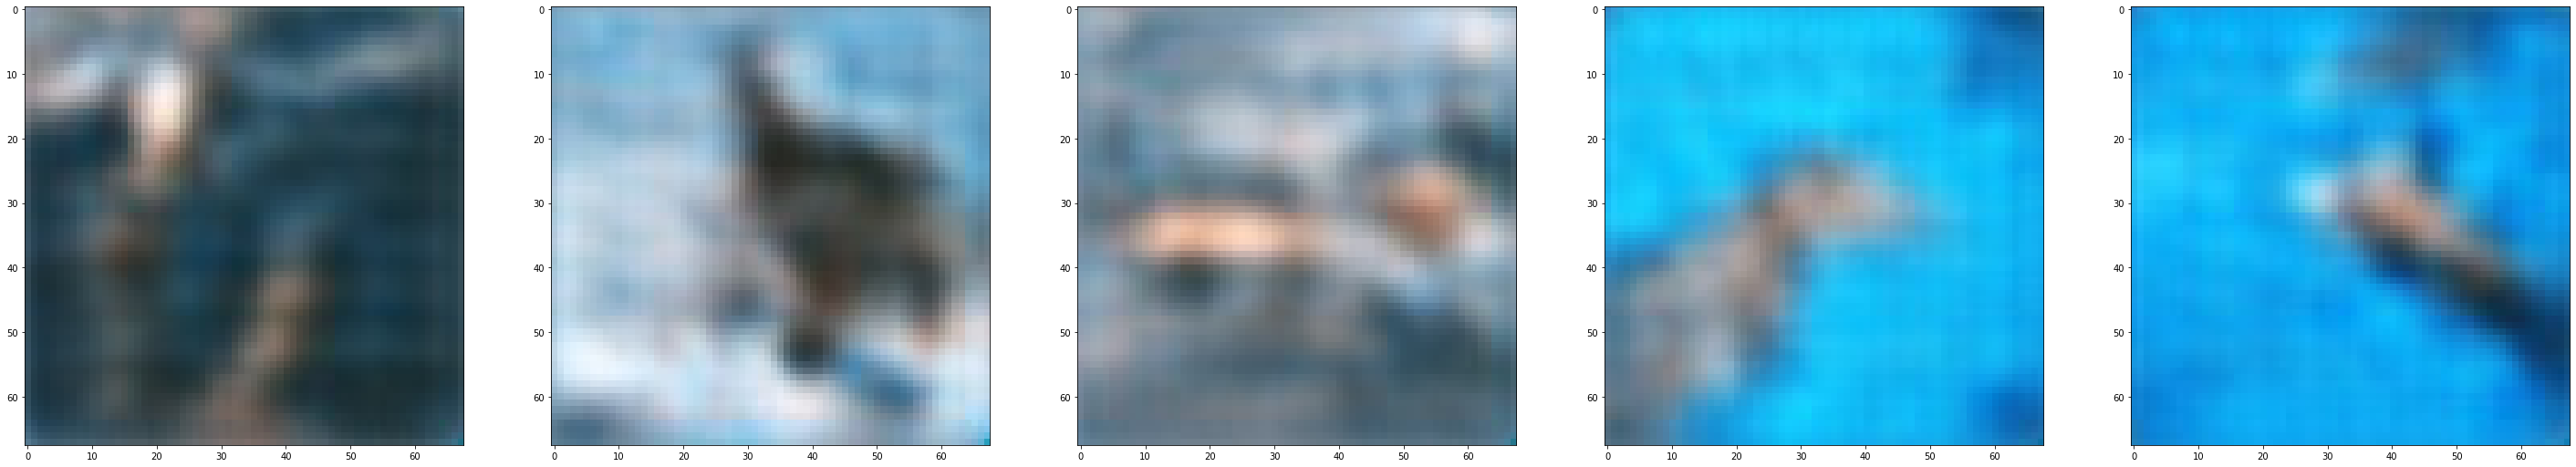

In [11]:
# Display 5 images from the input data
display_segmentation_images(conn, 
                            image_data.name, 
                            n_images=5, 
                            image_column='_image_', 
                            segmentation_labels_table=image_data.name, 
                            label_column='_label_'
                           )

# Display the 5 corresponding reconstructed 
# images that were output by the model
display_segmentation_images(conn, 
                            'final_images_rescaled', 
                            n_images=5, 
                            image_column='_image_', 
                            segmentation_labels_table=image_data.name, 
                            label_column='_label_'
                           )

In [12]:
conn.endsession()

+ Elapsed: 0.000104s, sys: 9.8e-05s, mem: 0.203mb